<center><font size = "10"> Week 9 - Long-term plasticity <center>
<center><font size = "8"> Home work - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: Eliser Josan Romero
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

In [1]:
import neuron, time
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline


from tqdm import tqdm
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

# Recompile external files, load & initialize
!nrnivmodl
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

--No graphics will be displayed.


/home/biophysics-NX-450/Week_9
Mod files: "./VecStim.mod" "./stdp_cc.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


# <font color= 'red'>Ex 1:</font>  Evolution of synaptic conductance in STDP
    
<font size='3'> Let's explore further the changes of synaptic conductance over time in STDP. Go back to tutorial 1 section 3 and set up everything you need to run it. Once you are ready, expand the plot to 3x2, adding the following in the last row:
   - plot the total excitatory synaptic conductance 𝑔𝐸(𝑡) 
   - plot each of the synaptic conductance changes $g_i$ (similar to the $P_i(t)$ plot)


<font size='3'> With the help of these plots, answer the following questions:
   1) In the above, even though all the presynaptic neurons have the same average firing rate, many of the synapses seem to have been weakened? Did you expect that?
   2) Total synaptic conductance is fluctuating over time. How do you expect 𝑔𝐸 to fluctuate if synapses did not show any STDP like behavior?
   3) Do synaptic weights ever reach a stationary state when synapses show STDP?
    
<font size='3'><font color= 'red'>[2 pts]</font>

In [2]:
# Some functions to help you

# Define parameters of the STDP process
def default_pars_STDP(**kwargs):
    pars = {}
    
    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)
    
    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]
    
    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]
    
    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]
    return pars

def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains
    Args:
        pars            : parameter dictionary
        rate            : noise amplitute [Hz]
        n               : number of Poisson trains
        myseed          : random seed. int or boolean
    Returns:
        pre_spike_train : spike train matrix, ith row represents whether
                          there is a spike in ith spike train over time
                          (1 if spike, 0 otherwise)
    """
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : binary spike train input from
                             presynaptic excitatory neuron
    Returns:
        P                  : LTP ratio
    """
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # Calculate the delta increment dP
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP
    return P

# <font color='red'>Ex 2:</font> Evolution of synaptic weights and STDP conditions

<font size='3'> copy and use the widget at the end of tutorial 1 to explore how synaptic weights change over time and given different conditions:
   1) Increase the firing rate (i.e., 30 Hz) of presynaptic neurons, and investigate the effect on the dynamics of synaptic weight distribution
   2) halve the population size of presynaptic neurons, what do you observe? What happens if you double it?
   3) What happens if you double the EPSP time constant? How do you explain this?
   4) And if you decrease it to 4ms? What is the simple, smallest change you can make to reproduce the previous behavior? Can you find another, equivalent change that also does the same? Does this make sense with the previous answers?

<font color= 'red'>[2 pts]</font>

# <font color='red'>Ex 3:</font> Voltage-dependent plasticity model

The clopath et al. model can explain the dependence of not just timing but also frequency on plasticity.

Simulate the model as in tutorial 2 and vary both the spike timing and frequency of stimulation. 
For speed, use just one repetition of 5 spikes and an interstimulus interval of 400.
Use $\Delta t$ values -10, -7, -5, 5, 7, 10 ms and frequency values 2, 5, 10, 20, 40 Hz.
Plot the STDP curves for different frequencies on the same axis (allowing you to compare)

1. What is the effect of frequency on LTD and on LTP?
2. How does this effect result from the model?

<font color='red'> [2 pts]

In [3]:
DG = '$\Delta \\bar{g} $(% initial)'
FREQUENCY = 'frequency (Hz)'
DT = '$\Delta t (ms)$'

### Initializing a ball and stick neuron

We'll use a simplified neuron with two sections representing the soma and the apical dendrite.

In [4]:
h.load_file("stdrun.hoc")
def ball_and_stick():
    soma = h.Section(name='soma')
    soma.diam = 20
    soma.L = 20
    apical = h.Section(name='apical')
    apical.diam = 10
    apical.L = 40
    apical.nseg=21
    apical.connect(soma(1))

    apical.insert('pas')
    soma.insert('hh')
    soma.insert('pas')
    for seg in soma:
        seg.hh.el =-70
        
    return soma, apical


soma, apical = ball_and_stick()
h.topology()


|-|       soma(0-1)
   `--------------------|       apical(0-1)



1.0

### The Clopath synapse model

In [5]:
def ccsynapse(segment):
    syn = h.STDPSynCC(segment)
    # depression threshold should be same as resting potential to reproduce LTD
    syn.tetam = segment.pas.e
    syn.tau_0 = 6
    syn.tau_y = 5
    syn.A_m = 14e-5
    syn.A_p = 8e-5
    syn.gbar=0.05
    return syn
synapse_soma = ccsynapse(soma(0.5))


### Simulation protocol

In [6]:
def STDP_simulation(
    soma,
    synapse,
    frequency=10, # Hz
    spike_offset=5, # ms
    interstimulus_interval=500, # ms
    nrepetitions=10,
    spikes_per_repetition=5,
    stim_amplitude=1, # nA
    stim_dur=1, # ms
    plot=True,
    view_closely=False
):
    """
    Simulate a STDP protocol with the provided soma and synapse.
    
    Run a protocol in which the synapse and soma are stimulated within a set window of each other.
    Plot a timeseries of the protocol and return the percent change in synaptic conductance.
    
    Arguments:
       soma: neuron section to treat as the soma.
       synapse: synapse object to stimulate.
       frequency: frequency of pre-post spike pairs during each repetition (in Hz).
       interstimulus_interval: interval between stimulation repetitions in ms.
       nrepetitions: number of repetitions of the protocol.
       spikes_per_repeition: number of pre and post spike pairs in each repeition.
       stim_amplitude: current for postsynaptic stimulus in nA.
       stim_dur: duration of postsynaptic stimulus in ms. 
           Current and duration should be sufficient to cause AP firing
       plot: whether or not to plot timeseries (default True)
       view_closely: whether to zoom in on the first spike for the plot
    """
    pre_stim_list = []
    post_stim = []
    t = 0
    for repetition in range(nrepetitions):
        t += interstimulus_interval
        for spike in range(spikes_per_repetition):
            pre_stim_list.append(t)
            post = h.IClamp(soma(0.5))
            post.delay = t + spike_offset
            post.amp = stim_amplitude
            post.dur = stim_dur
            post_stim.append(post)
            t += 1000 / frequency
            

    pre_stim = h.VecStim()
    t_stim_vec = h.Vector(pre_stim_list)
    pre_stim.play(t_stim_vec, None)
    connection = h.NetCon(pre_stim, synapse)
    connection.delay = 0
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    rec_g = h.Vector()
    rec_g.record(synapse._ref_g)
    rec_gbar = h.Vector()
    rec_gbar.record(synapse._ref_gbar)
    rec_i = h.Vector()
    rec_i.record(synapse._ref_i)
    rec_r = h.Vector()
    rec_r.record(synapse._ref_r)
    
    rec_um1 = h.Vector()
    rec_um1.record(synapse._ref_u_m1)
    rec_um2 = h.Vector()
    rec_um2.record(synapse._ref_u_m2)
    
    h.finitialize(-70)
    h.continuerun(t)
    
    
    time = np.array(rec_t)
    potential = np.array(rec_v)
    conductance = np.array(rec_g)
    current = np.array(rec_i)
    gbar = np.array(rec_gbar)
    spike_trace = np.array(rec_r)

    if plot:
        f, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
        f.suptitle(f'STDP simulation for frequency {frequency} Hz and $\Delta_t$ of {spike_offset} ms')
        axes[0].plot(time, potential, label='$V_m$')
        axes[0].vlines(np.array(pre_stim_list) + connection.delay, ymin=-70, ymax=20, color='k', label='pre_spikes')
        axes[0].hlines(synapse.tetam, label='$\\theta_{-}$', color='gray', xmin=time.min(), xmax=time.max())
        axes[0].hlines(synapse.tetap, label='$\\theta_{+}$', color='gray', xmin=time.min(), xmax=time.max())

        axes[0].vlines([post.delay for post in post_stim], ymin=-70, ymax=20, color='cyan', label='post_stims')
       
        axes[0].plot(time, rec_um1, label='$u_{-}$')
        axes[0].plot(time, rec_um2, label='$u_{+}$')
        
        def scale_secondary(values):
            return (values + 75) / 125
        
        def unscale_secondary(values):
            return (values * (125 / spike_trace.max())) - 75
            
        secax = axes[0].secondary_yaxis('right', functions=(scale_secondary, unscale_secondary))
        secax.set_ylabel('x (unitless)')

        axes[0].plot(time, unscale_secondary(spike_trace), label='$\\bar{x}$')
        
        if view_closely:
            plt.xlim(0, 3000)
        axes[0].set_ylabel('voltage (mV)')
        axes[1].set_xlabel('t (ms)')
        #axes[1].set_ylabel('$I_{syn} (nA)$')
        axes[1].set_ylabel('conductance (nS)')
        
        
        #axes[1].plot(time, current)
        axes[1].plot(time, conductance, label='$g_{syn}$')
        axes[1].plot(time, gbar, label='$\\bar{g}$')
        axes[1].set_ylim(conductance.min(), gbar.max() + 0.0001)
        axes[1].legend()
        #plt.title(f'frequency={frequency} Hz')
        plt.title(f'f={frequency} Hz, $\Delta_t$={spike_offset} ms') 
        axes[0].legend()

    return (gbar[-1] - gbar[0]) / gbar[0]
    

### LTP

0.259160406482582

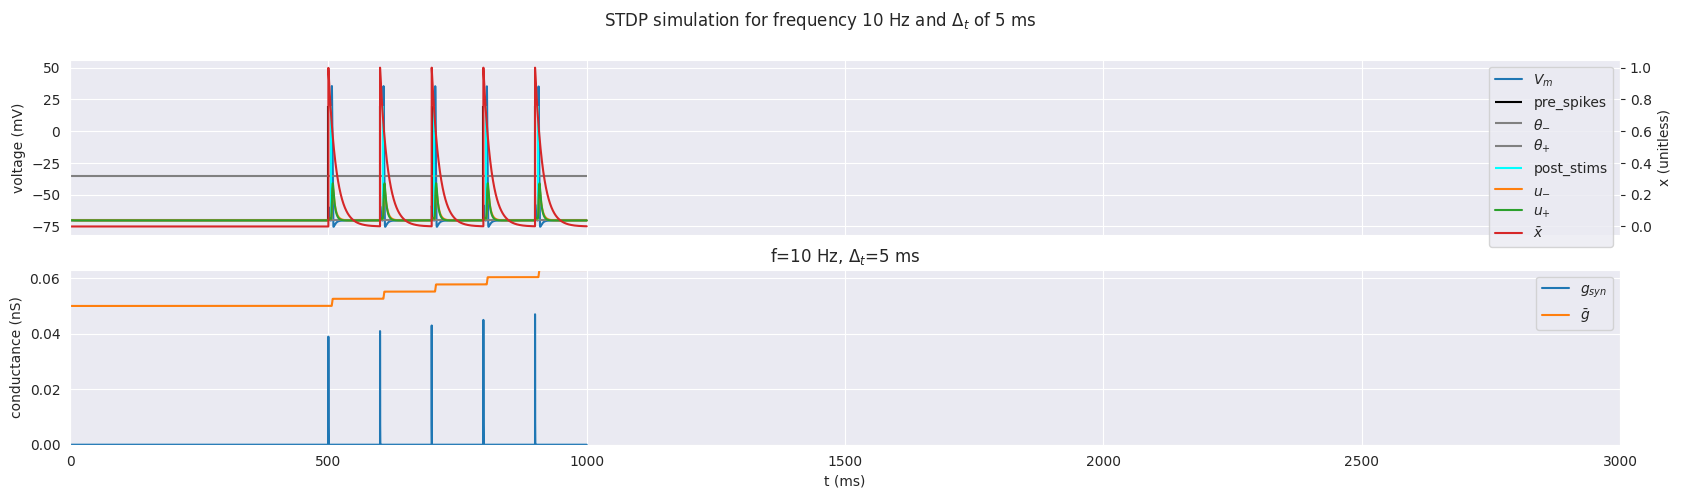

In [7]:
STDP_simulation(soma, synapse_soma, view_closely=True, nrepetitions=1)

### LTD

-0.27930517013516304

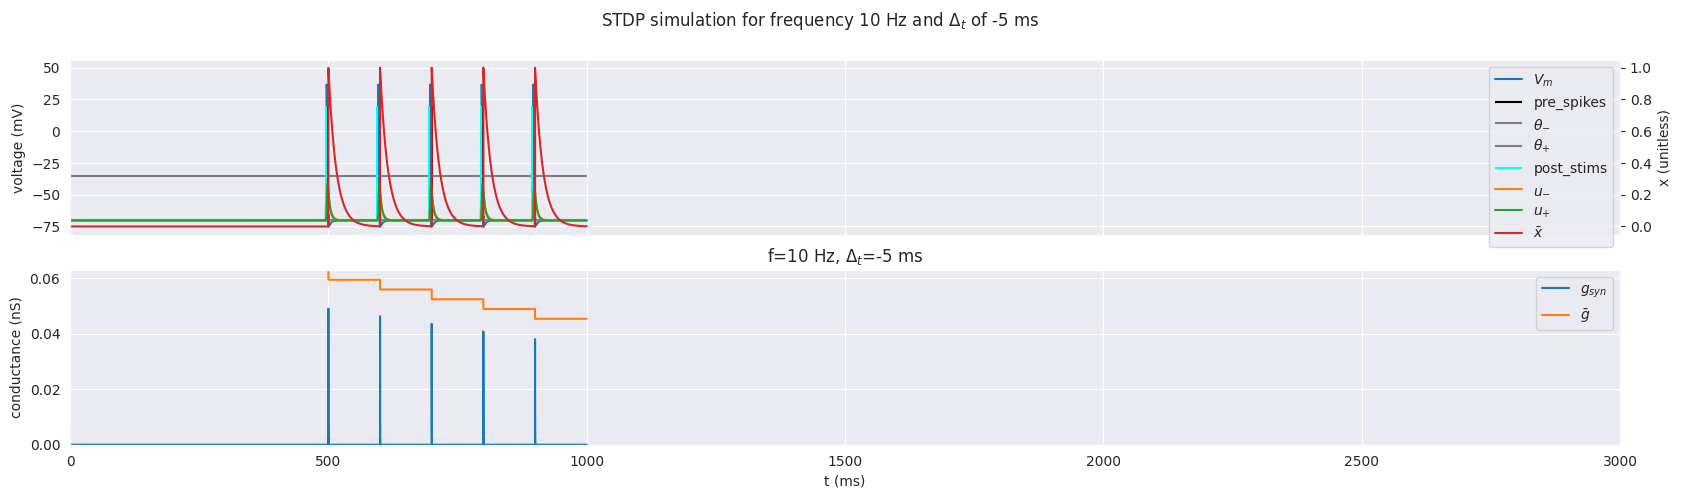

In [8]:
STDP_simulation(soma, synapse_soma, view_closely=True, nrepetitions=1, spike_offset=-5)

### STDP
Simulate the model as in tutorial 2 and vary both the spike timing and frequency of stimulation. 
For speed, use just one repetition of 5 spikes and an interstimulus interval of 400.
Use $\Delta t$ values -10, -7, -5, 5, 7, 10 ms and frequency values 2, 5, 10, 20, 40 Hz.
Plot the STDP curves for different frequencies on the same axis (allowing you to compare)



In [9]:
def stdp_1_freq(soma, apical, synapse_soma, df, tqdm, frequencies):
    data = []
    for spike_offset in tqdm:
        for frequency in frequencies:
            del soma, apical, synapse_soma
            soma, apical = ball_and_stick()
            synapse_soma = ccsynapse(soma(0.5))

            dgbar = STDP_simulation(
                soma, synapse_soma, view_closely = True, frequency=frequency, spike_offset=spike_offset,
                nrepetitions=1, spikes_per_repetition=5, interstimulus_interval=400)

            data.append({
                DG: dgbar * 100,
                FREQUENCY: frequency,
                DT: spike_offset})
        

    
    data = pd.DataFrame(data)
    new_df = pd.concat([df, data])
    return new_df

/tmp/ipykernel_804/2424578272.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True)


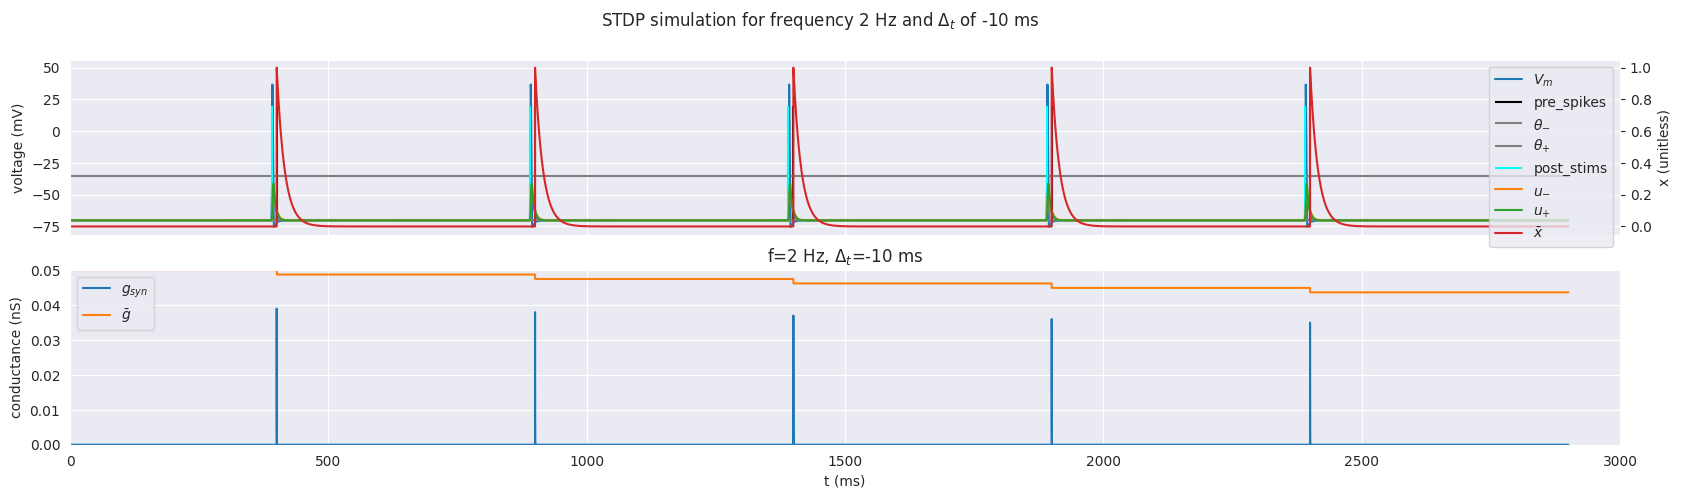

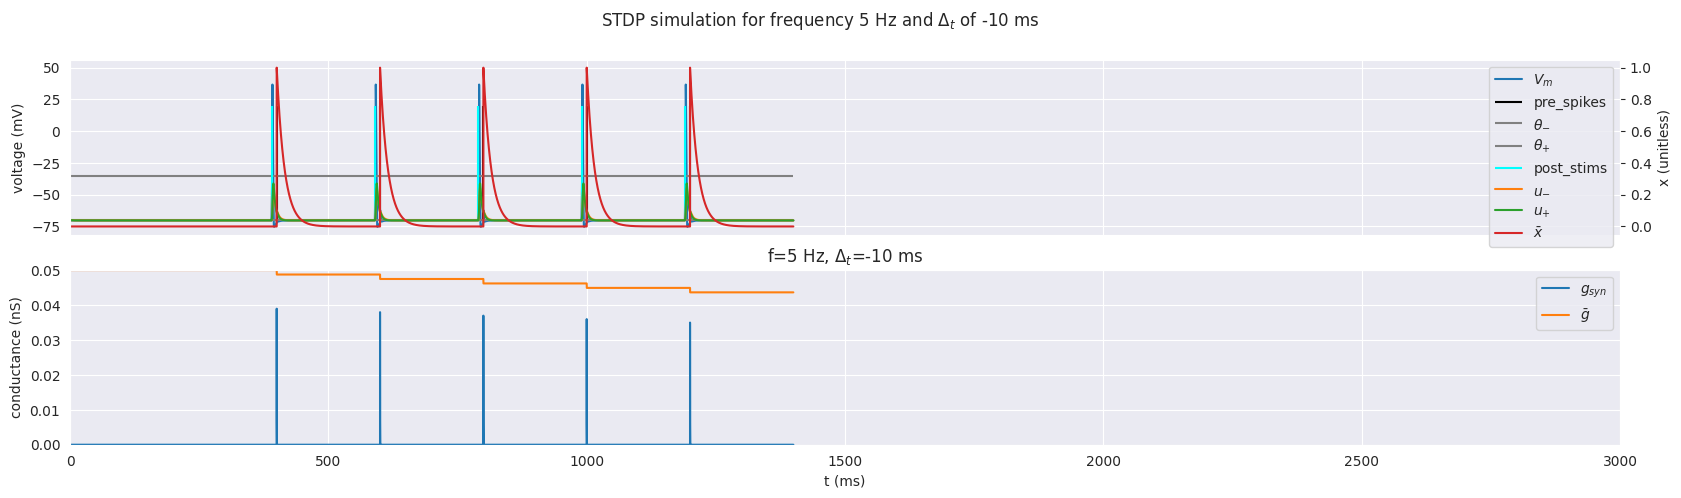

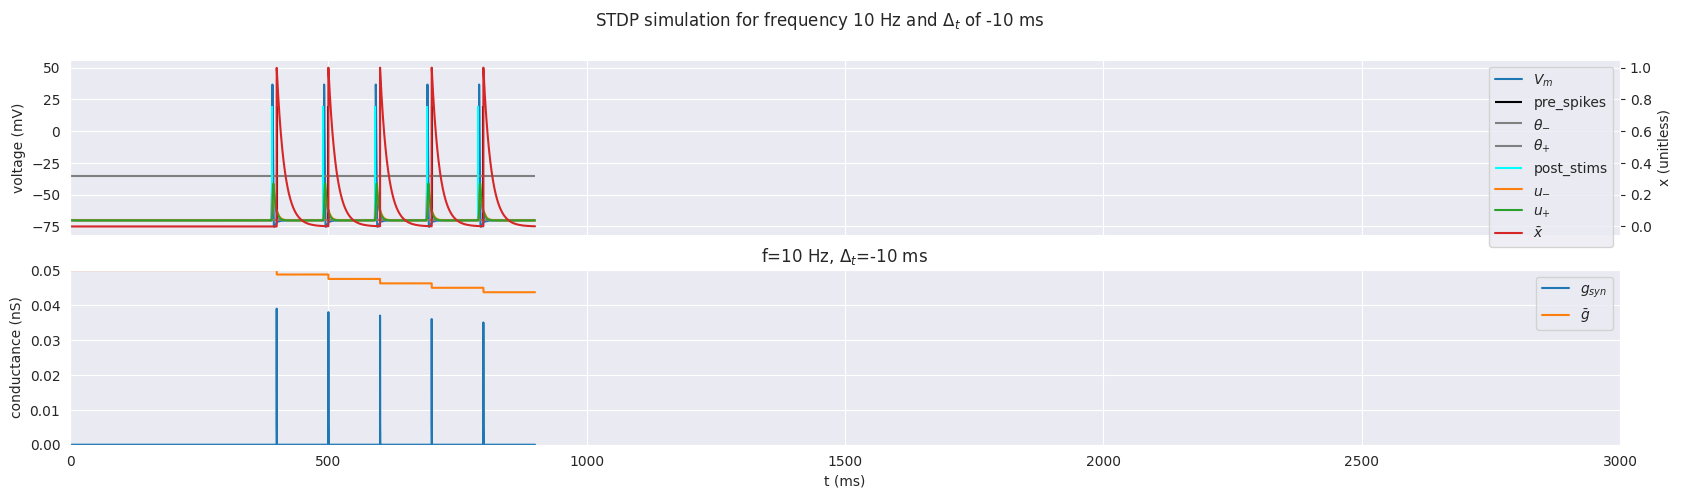

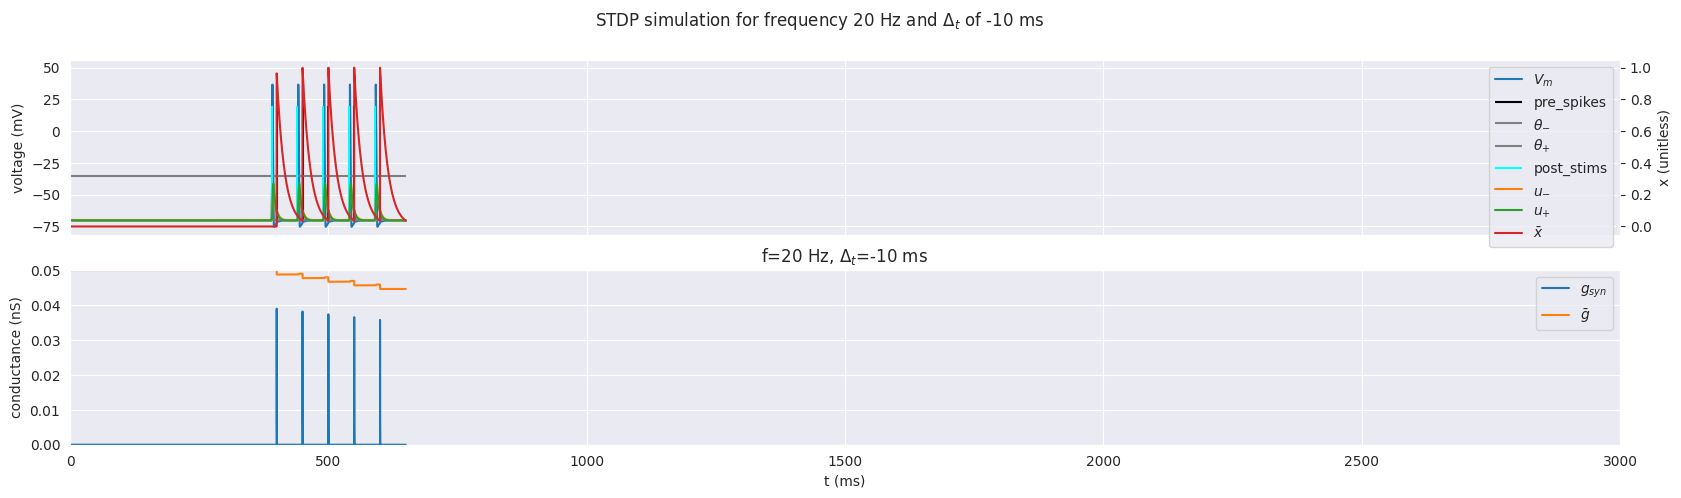

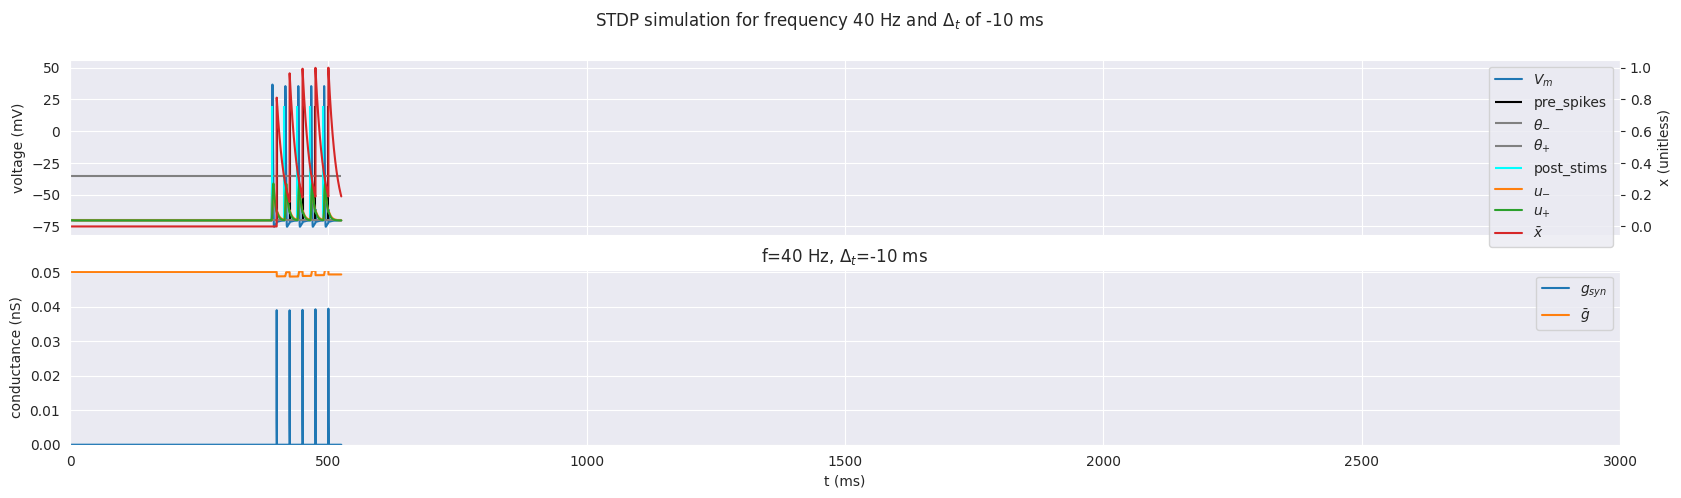

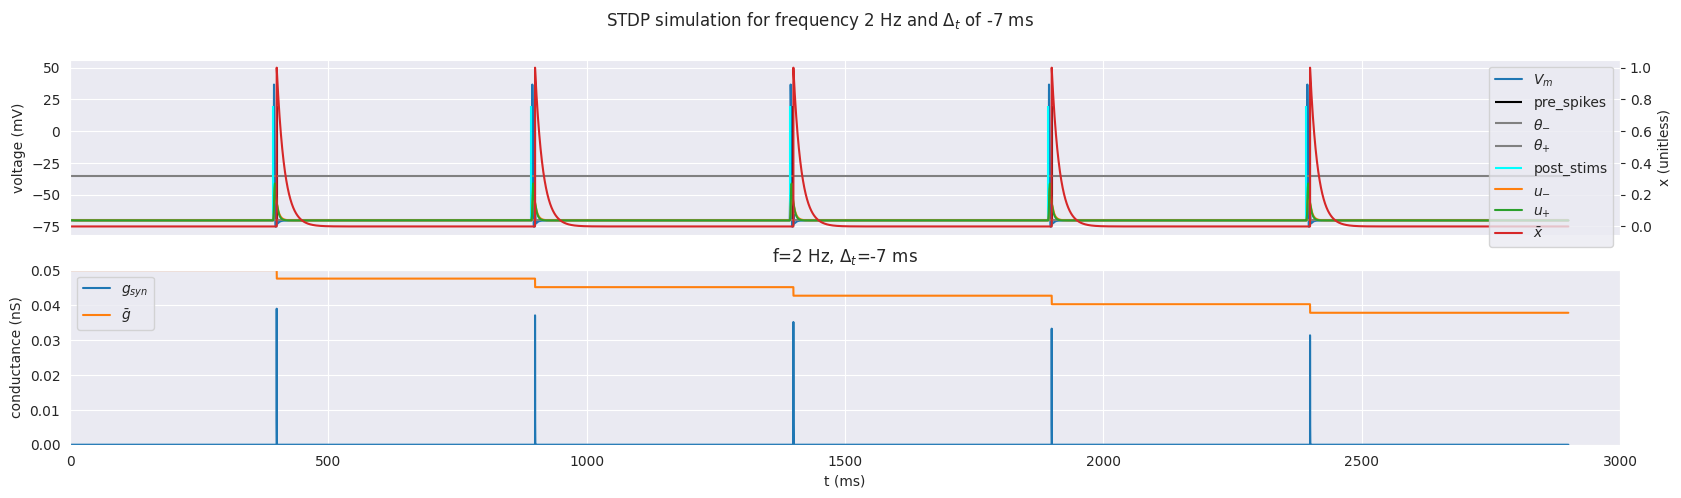

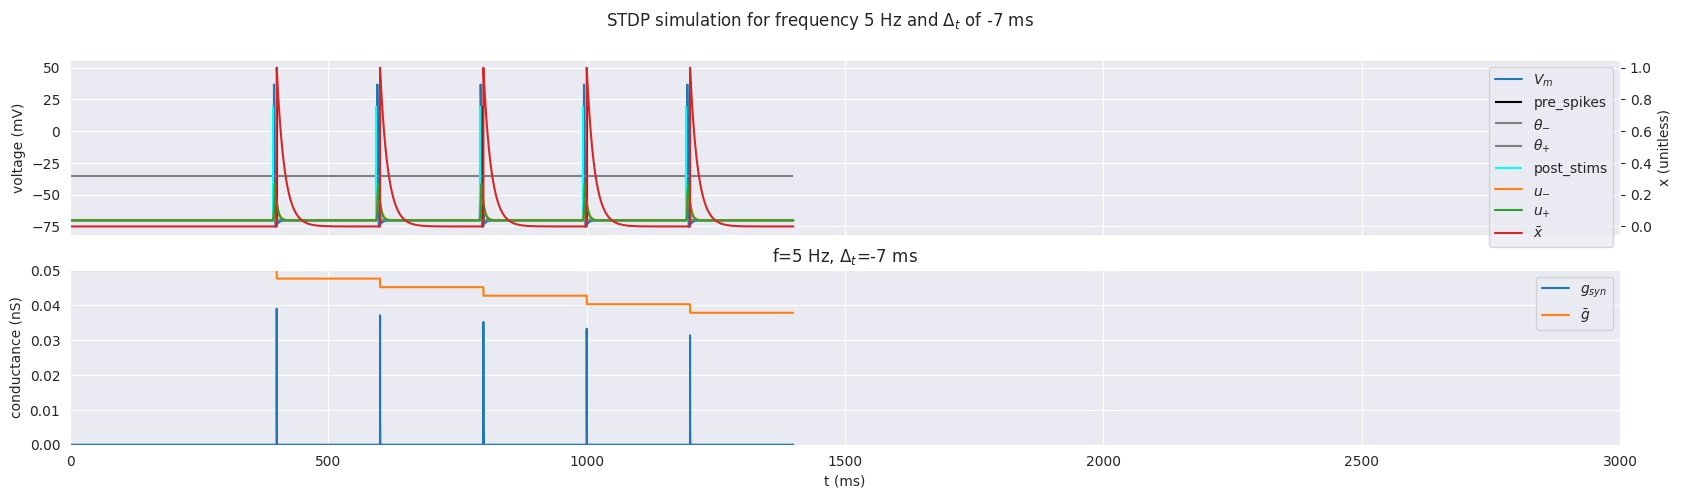

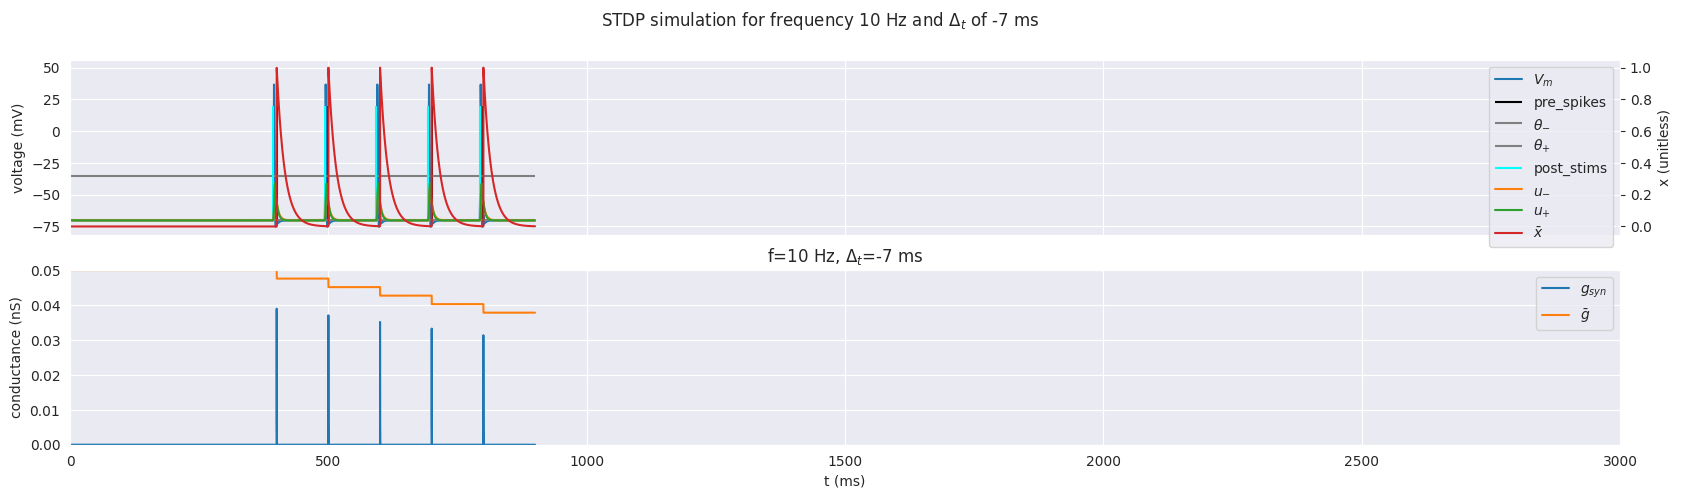

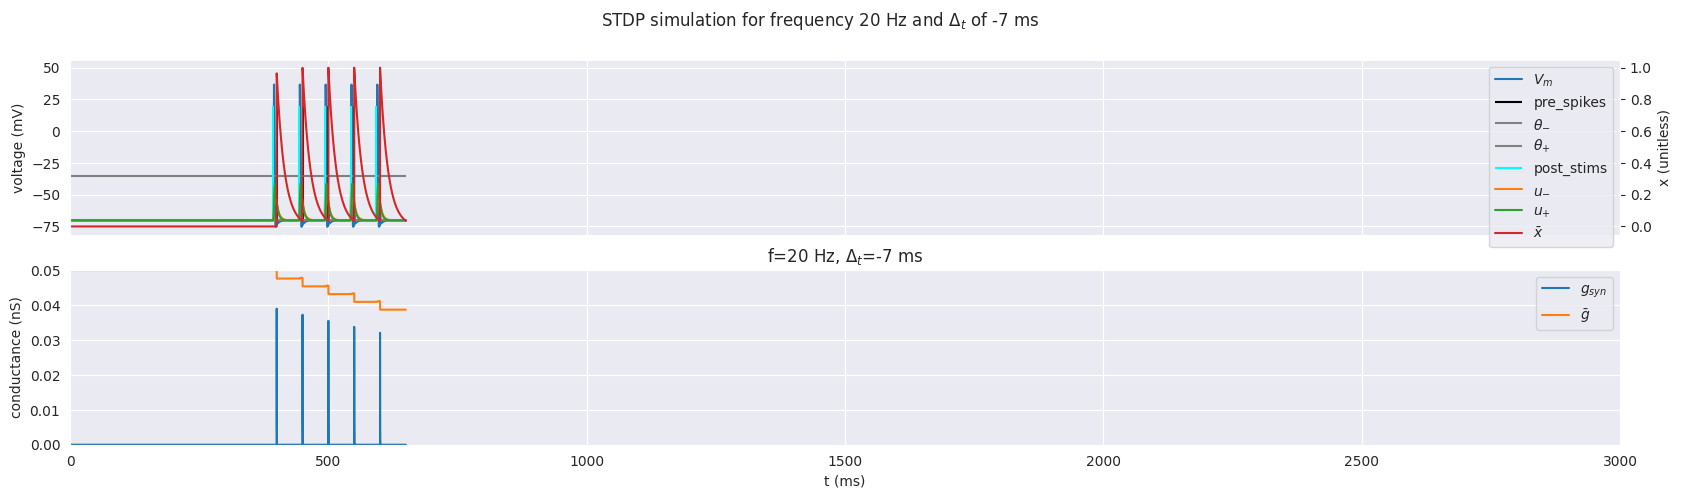

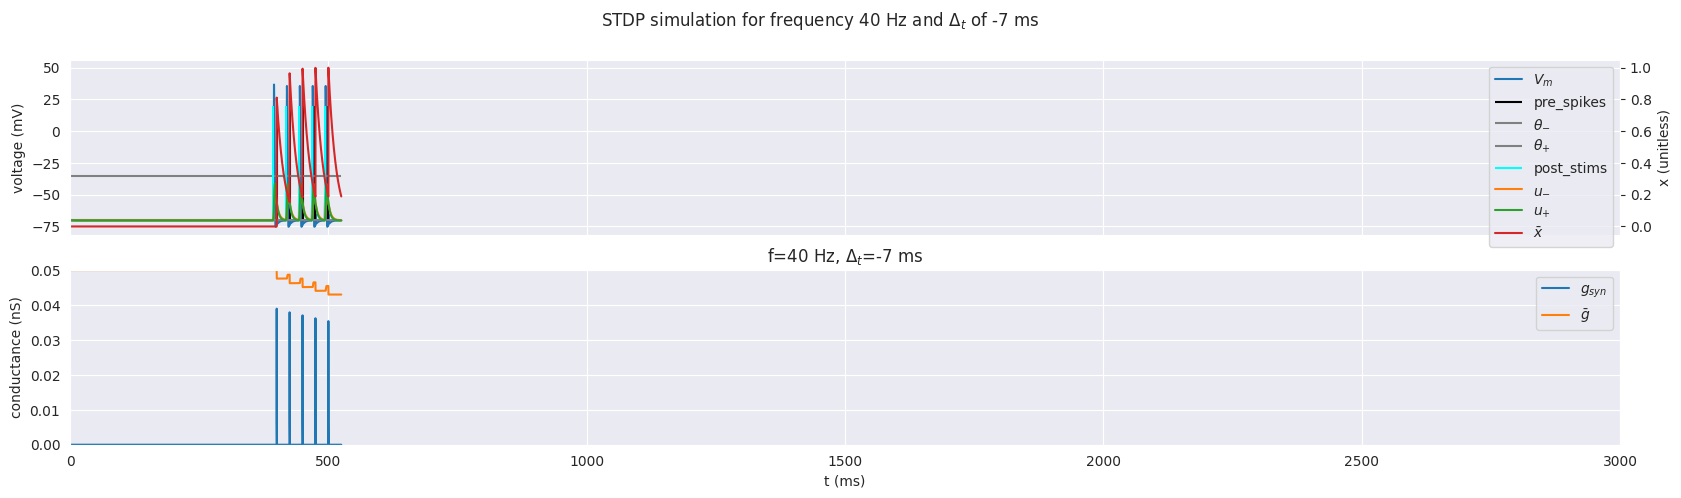

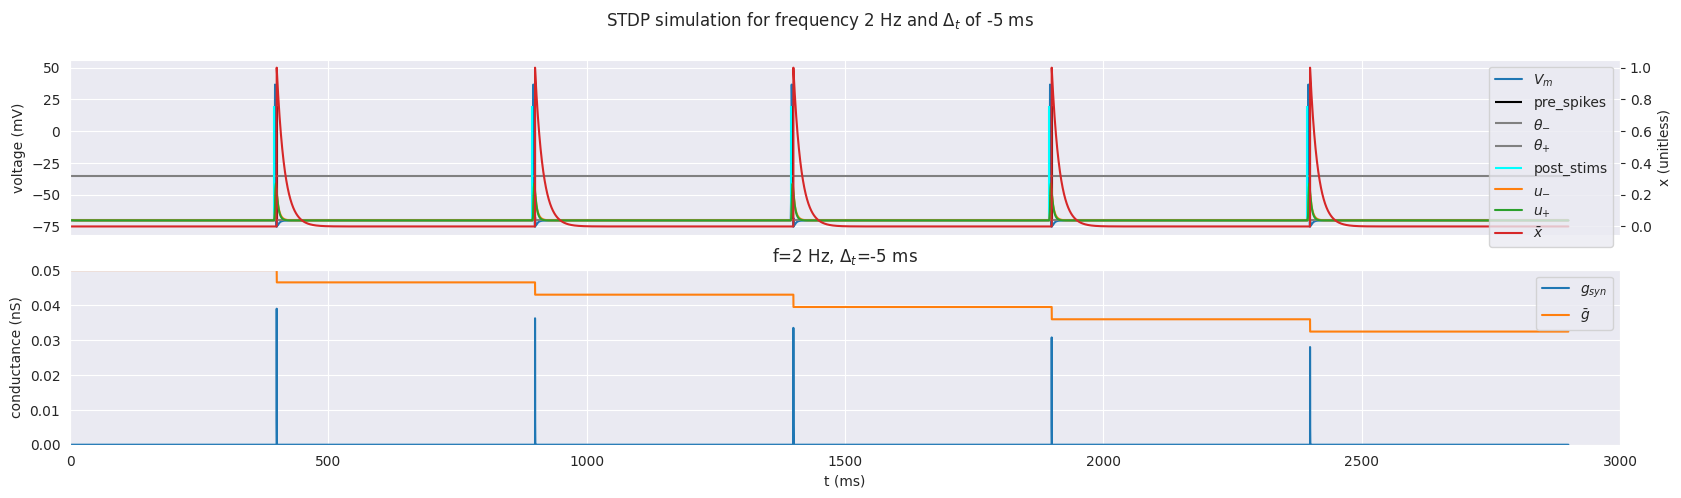

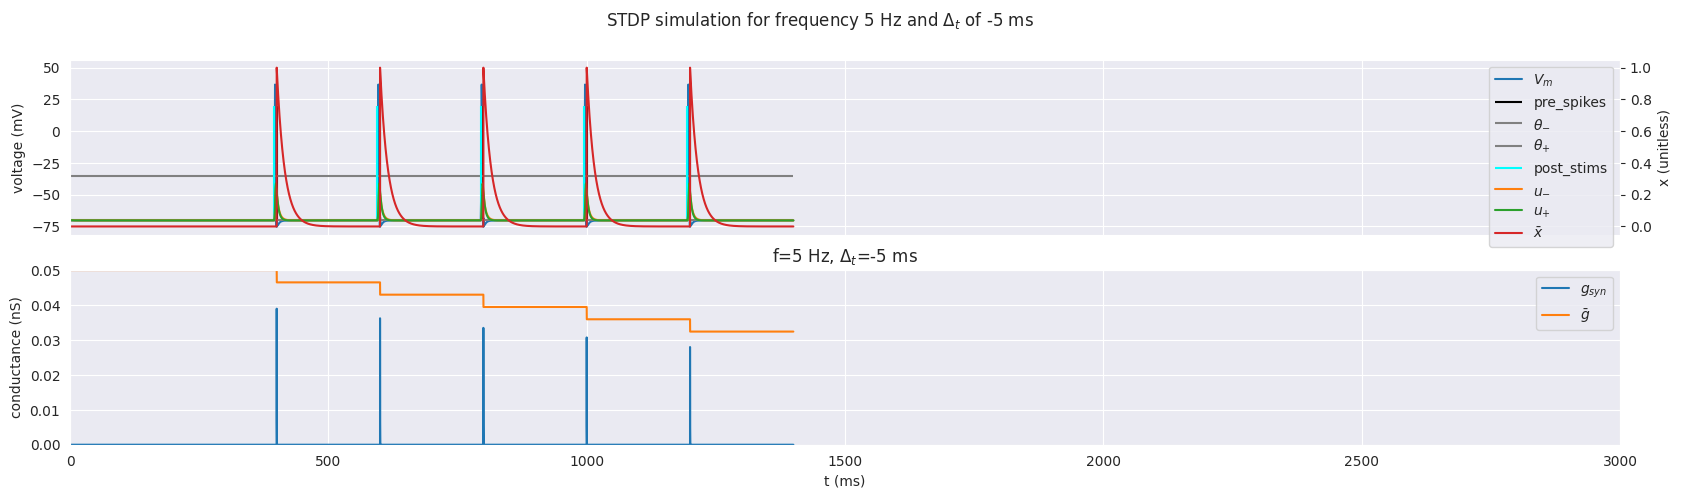

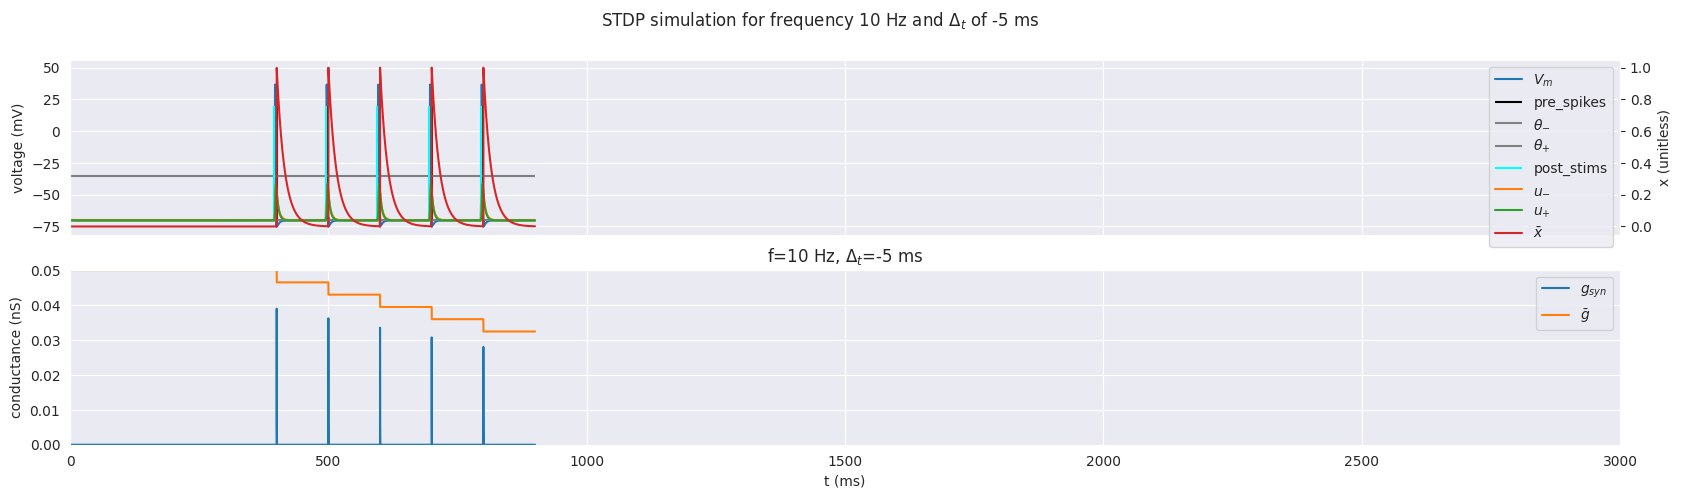

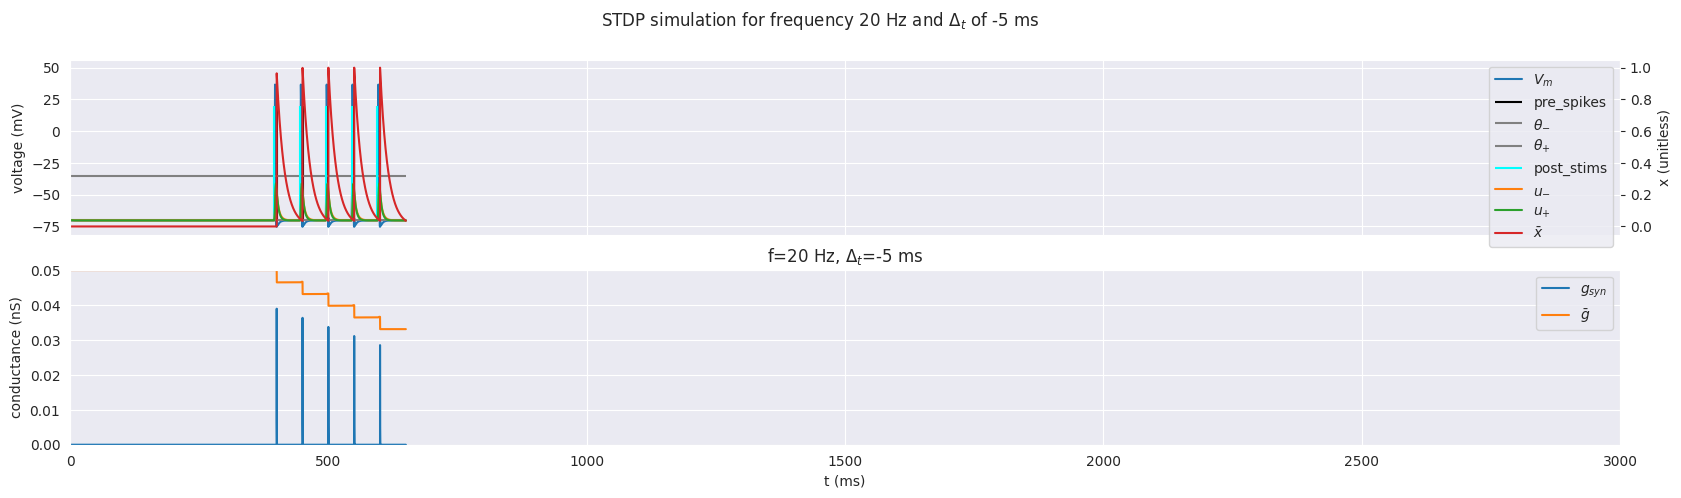

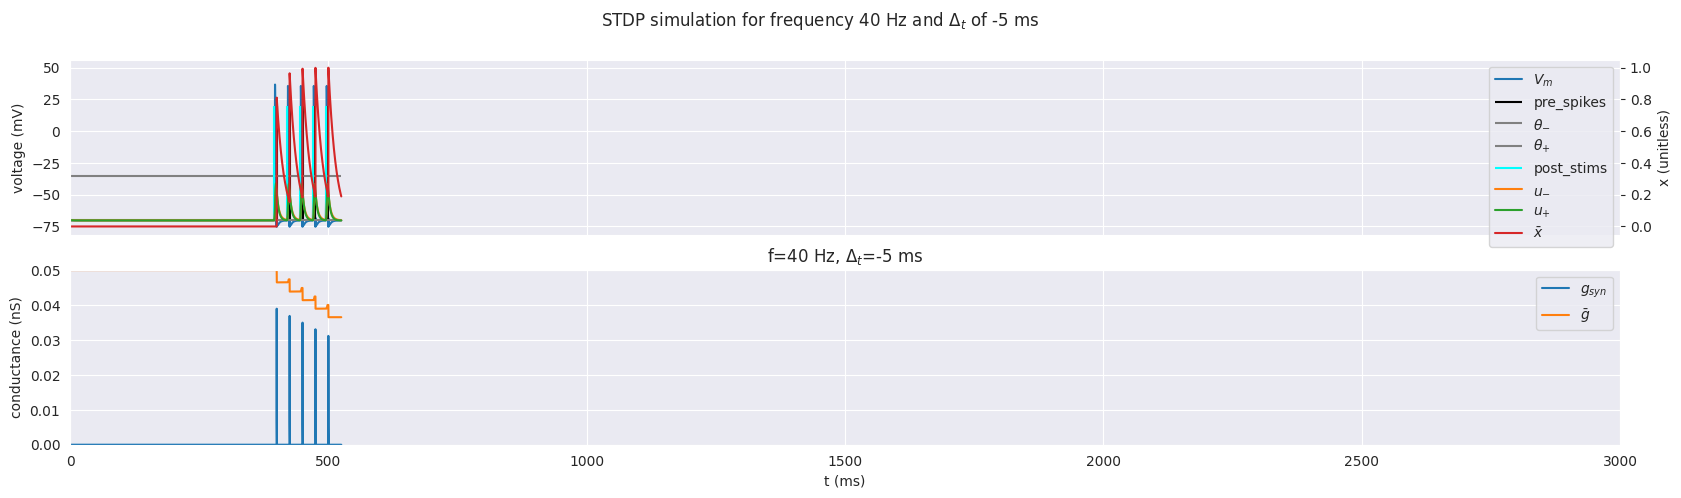

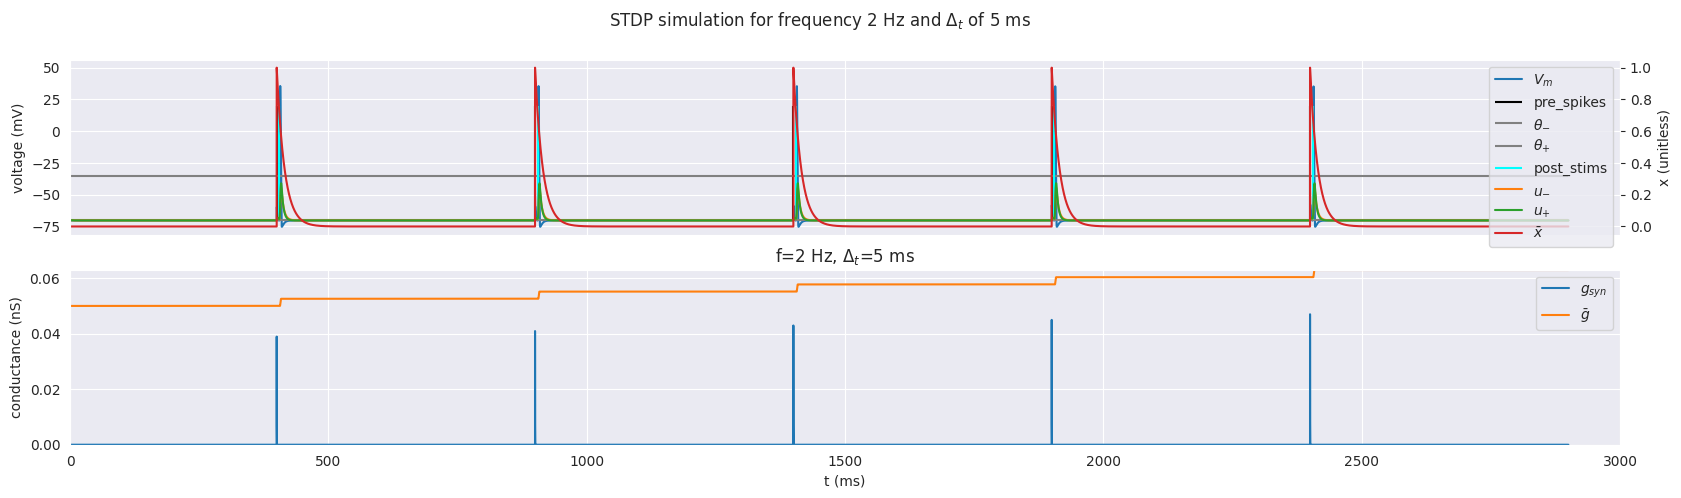

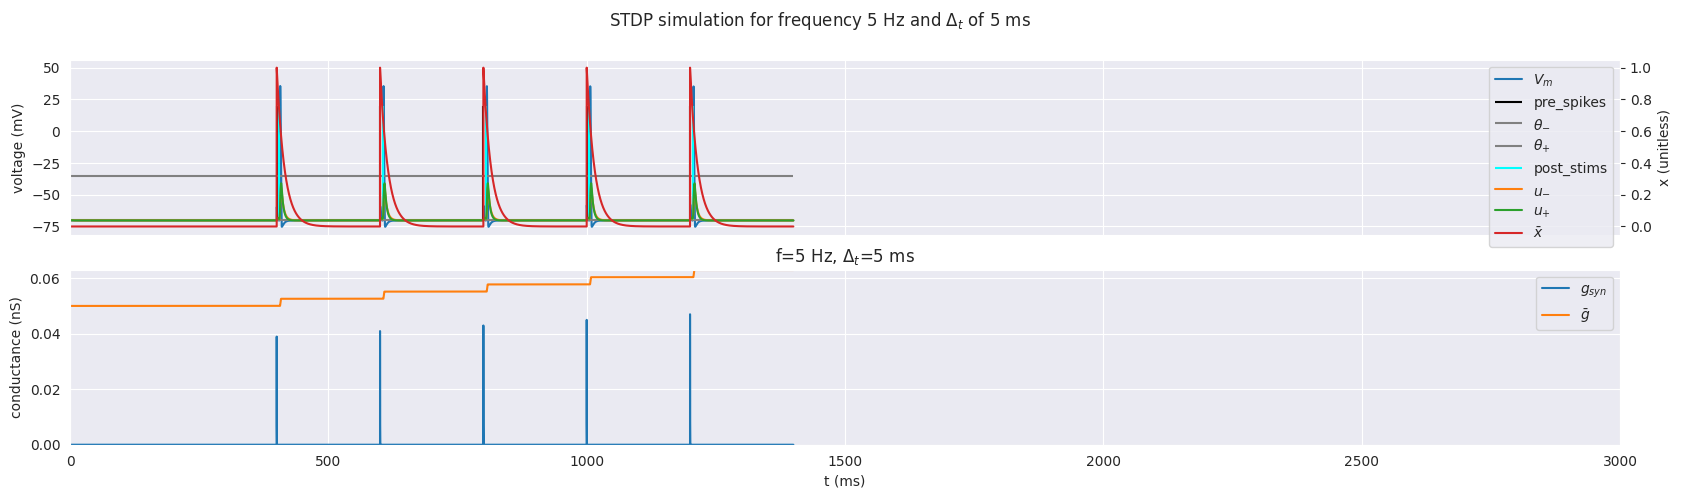

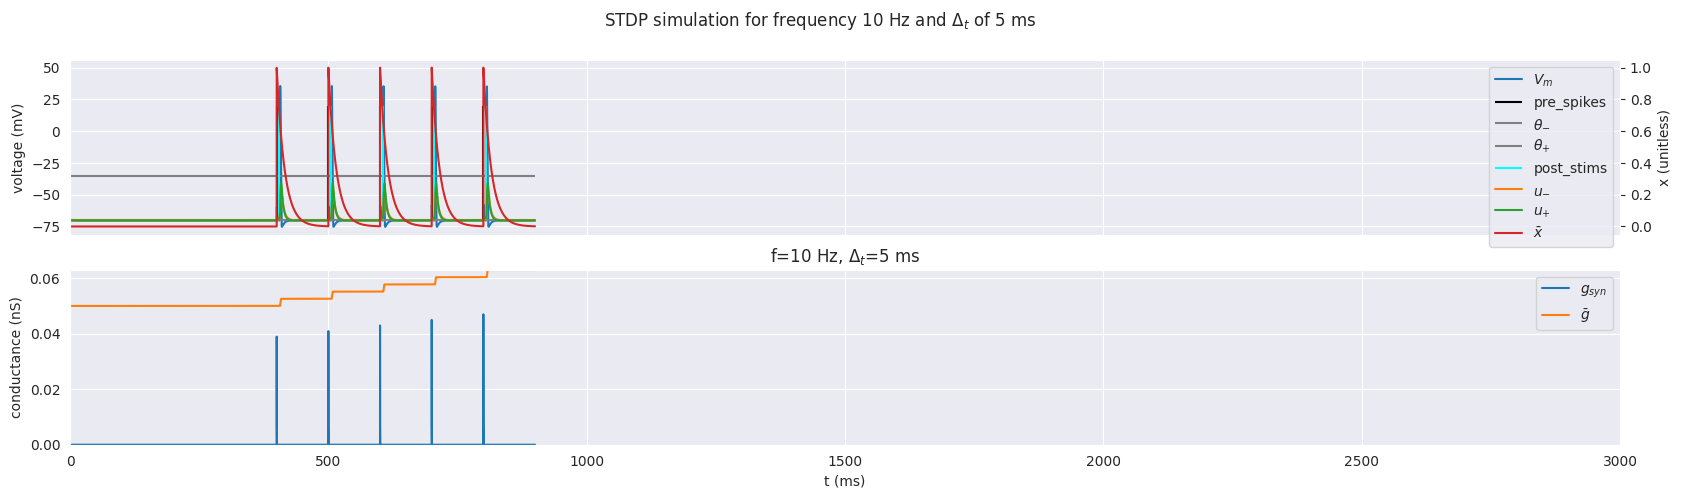

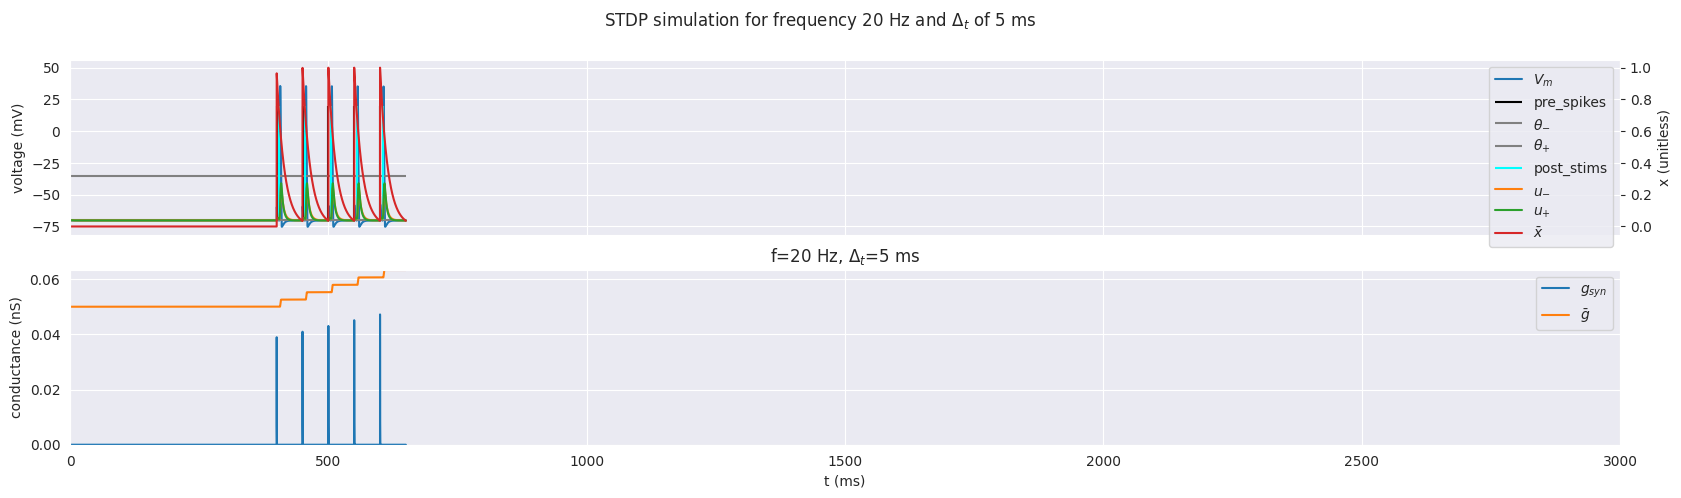

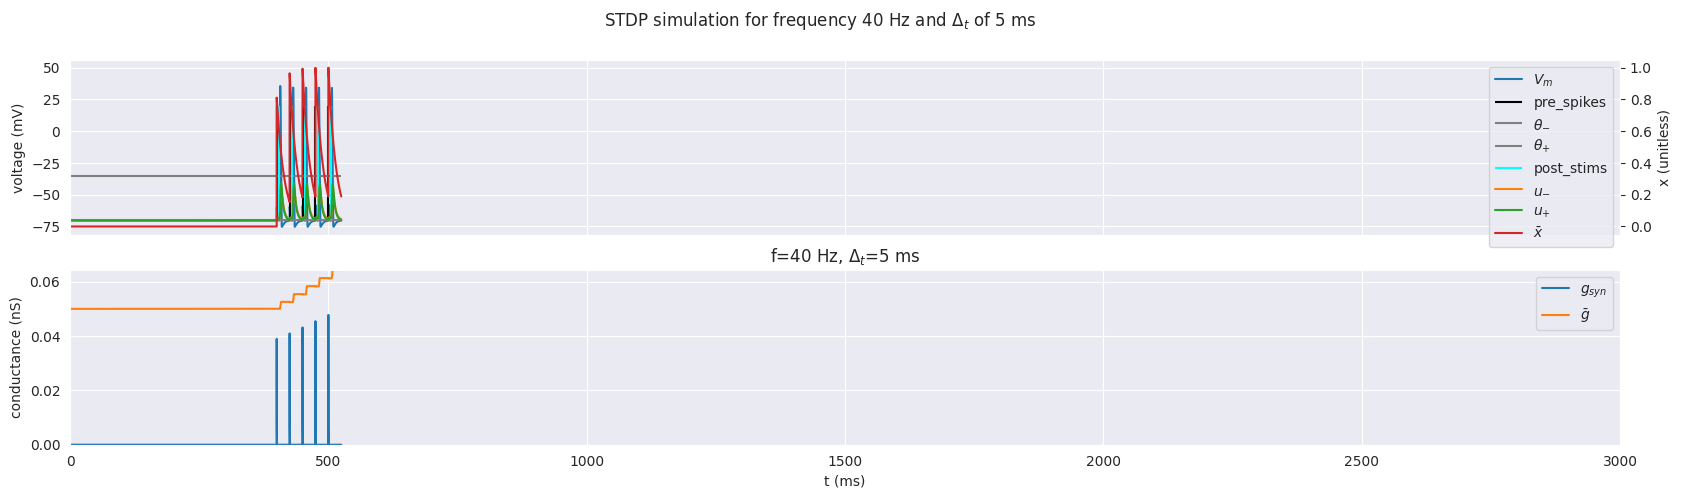

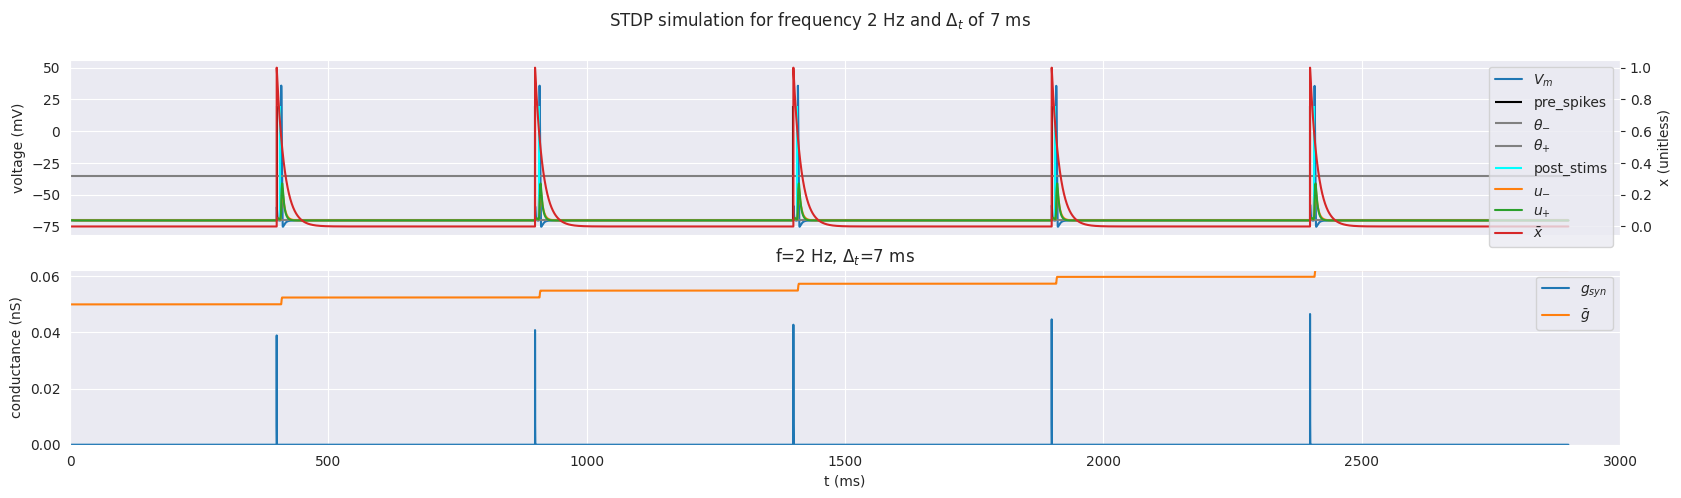

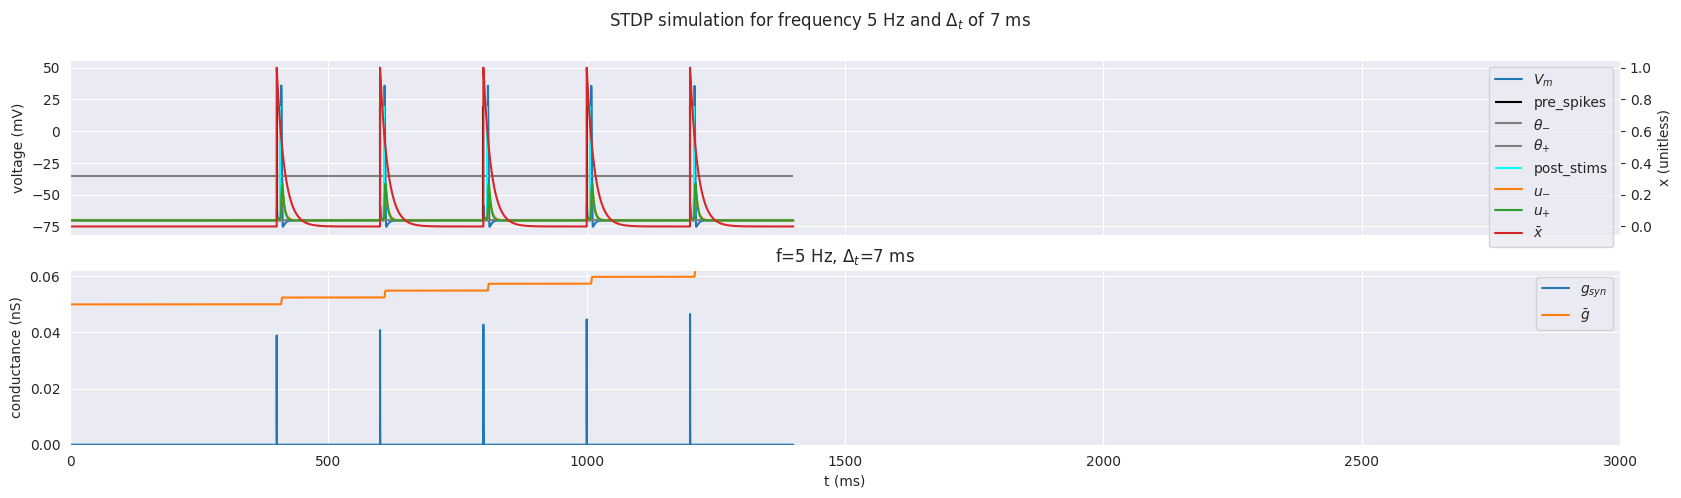

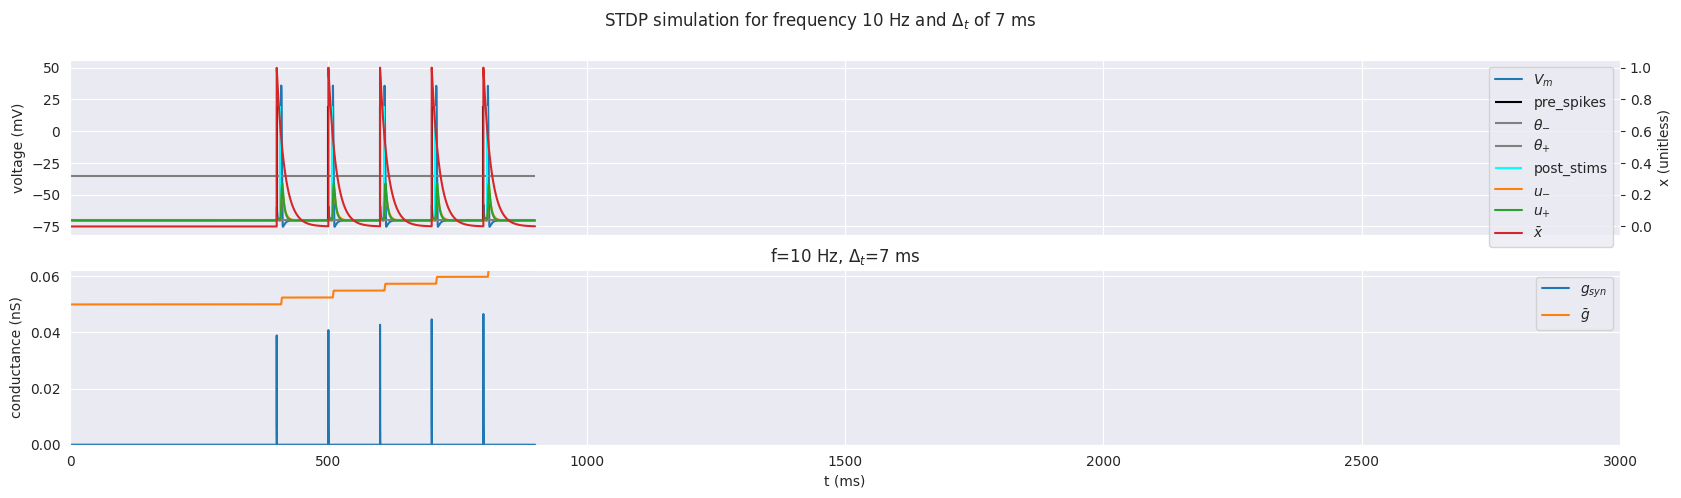

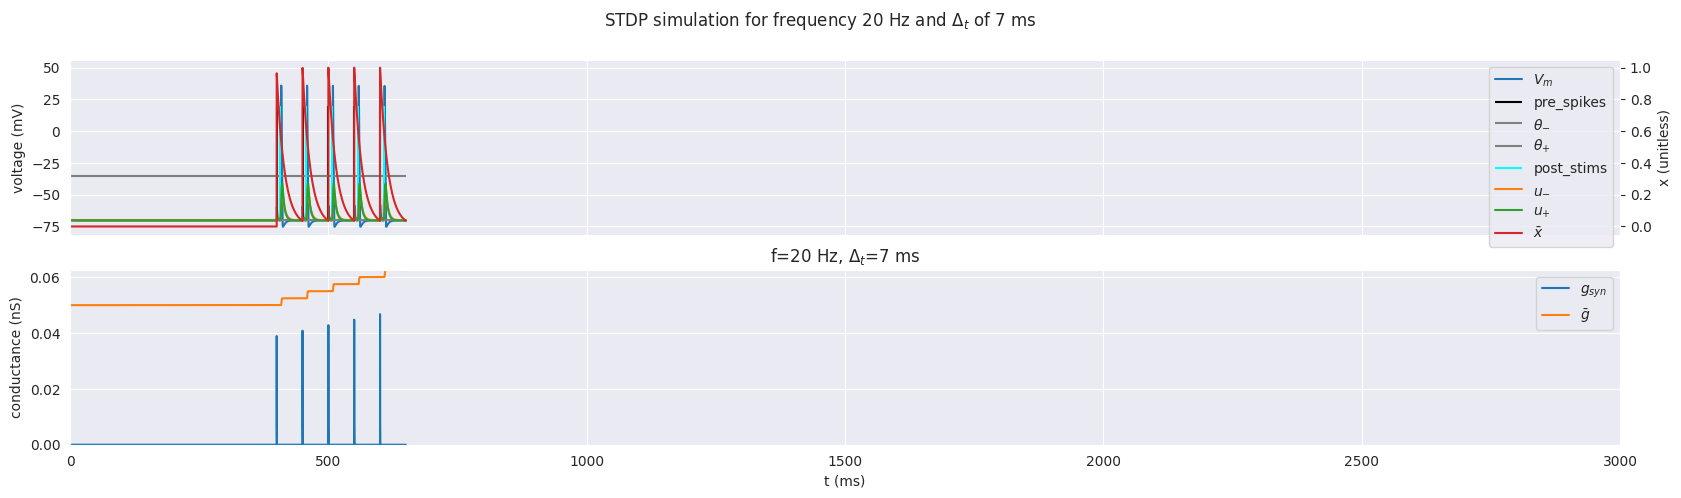

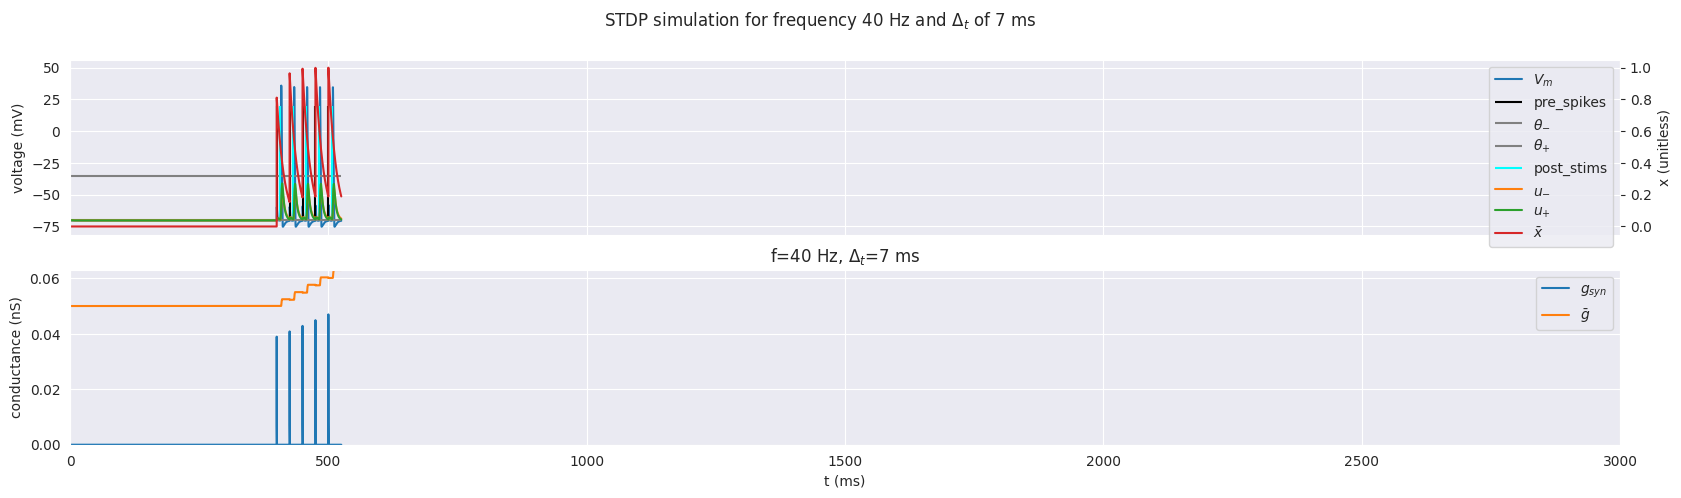

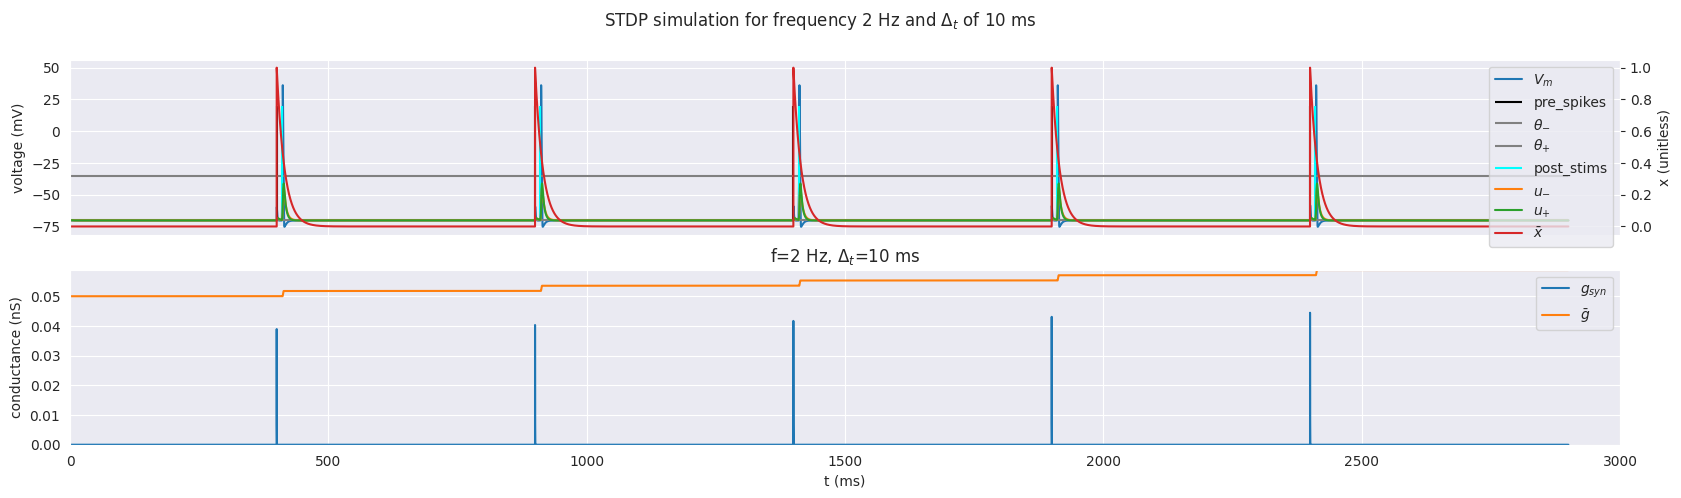

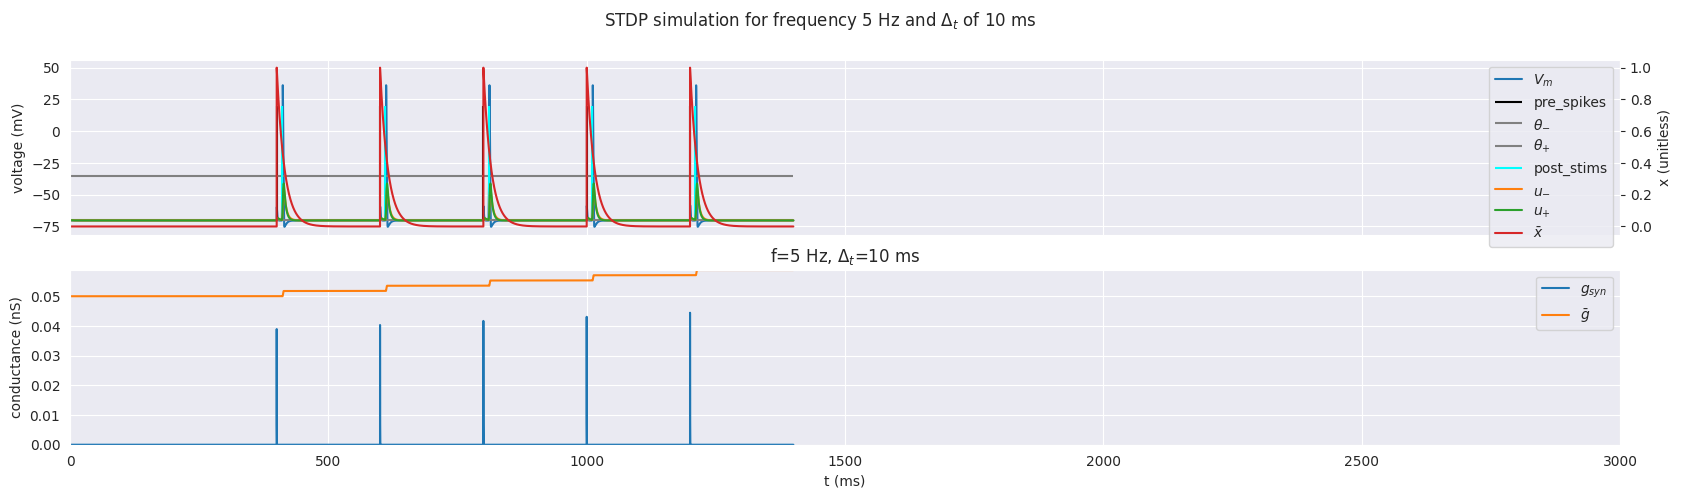

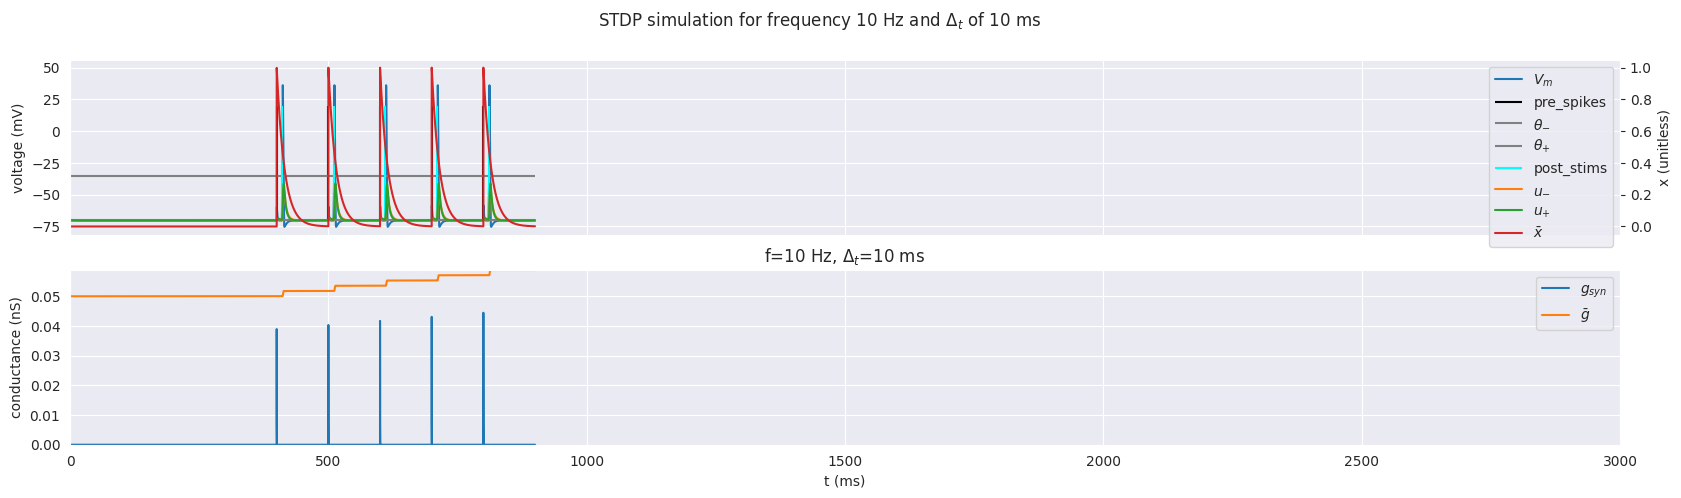

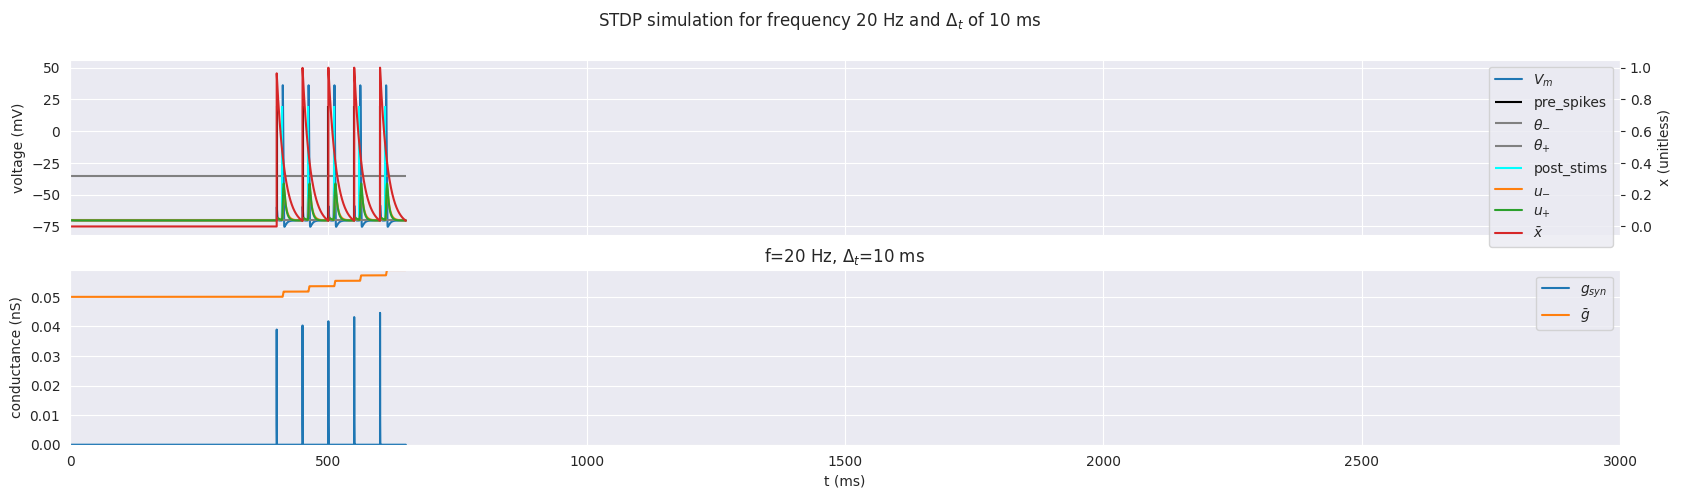

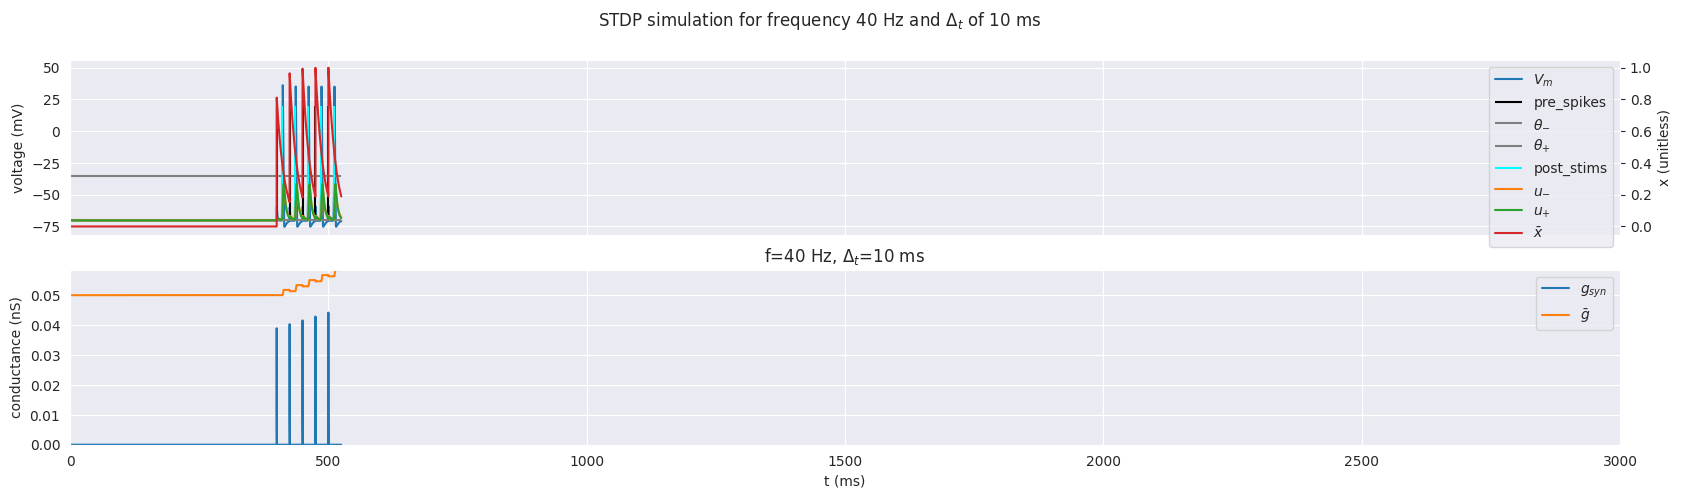

In [10]:
df = pd.DataFrame()
frequencies = [2, 5, 10, 20, 40] # Hz
spike_offset = 5
tqdm = [ -10, -7, -5, 5, 7, 10] # delta_ts ms
df = stdp_1_freq(soma, apical, synapse_soma, df, tqdm, frequencies)

In [11]:
df

,$\Delta \bar{g} $(% initial),frequency (Hz),$\Delta t (ms)$
0,-12.755273,2,-10
1,-12.755187,5,-10
2,-12.688020,10,-10
3,-10.818128,20,-10
4,-1.444352,40,-10
5,-24.449795,2,-7
6,-24.449716,5,-7
7,-24.388054,10,-7
8,-22.666174,20,-7
9,-14.009104,40,-7


1. What is the effect of frequency on LTD and on LTP?
> We can see that as the frequency increases the time between spikes reduces both in LTD and LTP simulattions. If not they behave as expected without changing $\bar{g}$'s curve. it also reduces the overall time of the simulation
2. How does this effect result from the model?
> The overall time of the stimulation dicreases in relatively to the frequency.